# Predict NYC Airbnb rental price
 
#### As of August 2019, this data set contains almost 50 thousand airbnb listings in NYC. The purpose of this task is to predict the price of NYC Airbnb rentals based on the data provided and any external dataset(s) with relevant information.

#### Columns -

id - listing ID <br>
Name- name of the listing<br>
host_id - host ID<br>
Host_name - name of the host<br>
Neighbourhood group - location<br>
Neighbourhood - area<br>
Latitude - latitude coordinates<br>
Longitude - longitude coordinates<br>
room_typelisting space type<br>
Price - price in dollars<br>
Minimum_nights - amount of nights minimum<br>
Number_of_reviews - number of reviews<br>
Last_review - latest review<br>
Reviews_per_month - number of reviews per month<br>
Calculated_host_listings_count - amount of listing per host<br>
Availability_365 - number of days when listing is available for booking<br>

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import tensorflow as tf

from scipy.stats import skew

import warnings
warnings.filterwarnings('ignore')

In [207]:
df = pd.read_csv('AB_NYC_2019.csv')
df.shape

(48895, 16)

In [208]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [209]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [210]:
(df.isnull().sum()*100)/len(df)

id                                 0.000000
name                               0.032723
host_id                            0.000000
host_name                          0.042949
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.558339
reviews_per_month                 20.558339
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [212]:
df.nunique()

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [213]:
(df.nunique()*100)/len(df)

id                                100.000000
name                               97.975253
host_id                            76.607015
host_name                          23.421618
neighbourhood_group                 0.010226
neighbourhood                       0.451989
latitude                           38.956949
longitude                          30.101237
room_type                           0.006136
price                               1.378464
minimum_nights                      0.222927
number_of_reviews                   0.805808
last_review                         3.607731
reviews_per_month                   1.916351
calculated_host_listings_count      0.096124
availability_365                    0.748543
dtype: float64

In [214]:
df[df['reviews_per_month'].isnull()]['number_of_reviews'].unique()

array([0], dtype=int64)

In [215]:
df[df['reviews_per_month'].isnull()]['number_of_reviews'].unique()

array([0], dtype=int64)

---

### Findings and Assumptions

#### First, we will attempt to clean the data. The below steps will be done. Additional steps might be done as we progress

- The columns - 'id', 'name', 'host_id' - have a lot of unqiue values. We can proceed with dropping these columns.
- 'host_name' can also be dropped.
- Wherever there is a NaN value in 'reviews_per_month', the value is '0' for 'number_of_reviews'. We can change all these NaN values to '0'.
- Some hosts seem to have multiple listings. We will check for duplicate data.
- For the catgorical columns, we will perform encoding before building the models.
- For a NN architecture, we would need to standardize on the data.

---

In [216]:
# Replacing NaN values under 'reviews_per_month' with 0.

df['reviews_per_month'].fillna(0, inplace=True)

In [217]:
dup_host_id = df[df.duplicated('host_id')]
dup_host_id.sort_values('host_id')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
13583,10160215,Torre del Lago Room.,2787,John,Brooklyn,Gravesend,40.60755,-73.97410,Private room,79,1,17,2019-06-26,0.40,6,174
13688,10267242,Cinque Terre Room. Clean and Quiet Queen Bedroom,2787,John,Brooklyn,Gravesend,40.60810,-73.97541,Private room,149,1,24,2019-05-11,0.64,6,180
10372,7937553,Riomaggiore Room. Queen Bedroom in Bklyn Townh...,2787,John,Brooklyn,Bensonhurst,40.60951,-73.97622,Private room,99,1,21,2018-10-27,0.50,6,153
21556,17263207,Brooklyn home. Comfort and clean. Liguria room.,2787,John,Brooklyn,Bensonhurst,40.60877,-73.97382,Private room,49,1,19,2019-06-08,0.70,6,360
13963,10593675,"La Spezia room. Clean, quiet and comfortable bed",2787,John,Brooklyn,Bensonhurst,40.60951,-73.97642,Shared room,79,1,15,2018-09-29,0.43,6,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48633,36351030,Brand New Privated Room for NYC Traveler,273354185,Lee & Luffy,Bronx,Castle Hill,40.81709,-73.84811,Private room,39,2,0,NaN,0.00,7,177
48631,36350749,NYC Traveler Get Away Private ROOM #3,273354185,Lee & Luffy,Bronx,Castle Hill,40.81572,-73.84592,Private room,39,2,0,NaN,0.00,7,177
48687,36384346,"✨Superior King Room , Manhattan View✨",273392981,Giorgio Residence,Queens,Long Island City,40.75615,-73.94121,Private room,101,1,0,NaN,0.00,3,365
48696,36388492,"✨Premier King Room , City View✨",273392981,Giorgio Residence,Queens,Long Island City,40.75559,-73.94106,Private room,101,1,0,NaN,0.00,3,361


#### It would seem that some hosts own more than one apartment. We will not drop any row.

In [218]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [219]:
df['calculated_host_listings_count'].unique()

array([  6,   2,   1,   4,   3,   5,   7,  13,  28,  11,   8,   9,  52,
        18,  15,  19,  10,  39,  26,  29,  12,  21,  96,  14,  34,  43,
       121,  37,  49,  31,  91,  16,  87,  33,  23,  50,  20,  25, 232,
        17,  47, 103,  65,  30,  27, 327,  32], dtype=int64)

In [220]:
len(df['calculated_host_listings_count'].unique())

47

In [221]:
df[df['calculated_host_listings_count']==327]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
38293,30181691,Sonder | 180 Water | Incredible 2BR + Rooftop,219517861,Sonder (NYC),Manhattan,Financial District,40.70637,-74.00645,Entire home/apt,302,29,0,NaN,0.00,327,309
38294,30181945,Sonder | 180 Water | Premier 1BR + Rooftop,219517861,Sonder (NYC),Manhattan,Financial District,40.70771,-74.00641,Entire home/apt,229,29,1,2019-05-29,0.73,327,219
38588,30347708,Sonder | 180 Water | Charming 1BR + Rooftop,219517861,Sonder (NYC),Manhattan,Financial District,40.70743,-74.00443,Entire home/apt,232,29,1,2019-05-21,0.60,327,159
39769,30937590,Sonder | The Nash | Artsy 1BR + Rooftop,219517861,Sonder (NYC),Manhattan,Murray Hill,40.74792,-73.97614,Entire home/apt,262,2,8,2019-06-09,1.86,327,91
39770,30937591,Sonder | The Nash | Lovely Studio + Rooftop,219517861,Sonder (NYC),Manhattan,Murray Hill,40.74771,-73.97528,Entire home/apt,255,2,14,2019-06-10,2.59,327,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47691,35871510,Sonder | 116 John | Vibrant Studio + Fitness Room,219517861,Sonder (NYC),Manhattan,Financial District,40.70818,-74.00631,Entire home/apt,135,29,0,NaN,0.00,327,339
47692,35871511,Sonder | 116 John | Vibrant 1BR + Fitness Room,219517861,Sonder (NYC),Manhattan,Financial District,40.70691,-74.00682,Entire home/apt,165,29,0,NaN,0.00,327,342
47693,35871515,Sonder | 116 John | Stunning 1BR + Rooftop,219517861,Sonder (NYC),Manhattan,Financial District,40.70772,-74.00673,Entire home/apt,165,29,0,NaN,0.00,327,347
47814,35936418,Sonder | 116 John | Polished Studio + Gym,219517861,Sonder (NYC),Manhattan,Financial District,40.70840,-74.00518,Entire home/apt,699,29,0,NaN,0.00,327,327


In [222]:
df[df['calculated_host_listings_count']==32].head(8)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
40966,31874576,Chic Private Bedroom in Upper West Side 107,238321374,Eyal,Manhattan,Upper West Side,40.79884,-73.95983,Private room,60,30,2,2019-06-16,1.46,32,337
40967,31875616,Cozy Private Bedroom in Upper West Side 107,238321374,Eyal,Manhattan,Upper West Side,40.79966,-73.96059,Private room,60,30,1,2019-06-09,1.00,32,333
40969,31875827,Artsy Private Bedroom in Upper West Side 107,238321374,Eyal,Manhattan,Upper West Side,40.80014,-73.96132,Private room,60,30,0,NaN,0.00,32,347
40970,31876014,Modern Bedroom in the Upper West Side 107,238321374,Eyal,Manhattan,Upper West Side,40.79880,-73.96096,Private room,60,30,0,NaN,0.00,32,342
40971,31876398,Airy Private Bedroom in Upper West Side 107,238321374,Eyal,Manhattan,Upper West Side,40.79821,-73.96090,Private room,60,30,0,NaN,0.00,32,356
40973,31876645,Artistic Private BR in Upper West Side 107,238321374,Eyal,Manhattan,Upper West Side,40.79971,-73.96075,Private room,60,30,0,NaN,0.00,32,364
40975,31876724,Vibrant Bedroom in Upper West Side 107,238321374,Eyal,Manhattan,Upper West Side,40.79887,-73.95968,Private room,60,30,1,2019-06-21,1.00,32,342
40976,31877020,Calming Private BR in Upper West Side 107,238321374,Eyal,Manhattan,Upper West Side,40.79959,-73.95924,Private room,60,30,1,2019-06-16,1.00,32,346


#### WOW! Some users do seem to be loaded and own a lot of property.
#### Owning a lot of property would not mean that the value could increase/decrease. Ideally, the location would dictate pricing. We can proceeding with dropping this column too.

In [223]:
# Dropping columns not required

df.drop(['id', 'name', 'host_id', 'host_name', 'last_review', 'calculated_host_listings_count'], axis=1, inplace=True)

In [224]:
df.head(7)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,0
5,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,129
6,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,0.40,0


#### We will now work with the above Data.
#### Before proceeding with creating a model, let us perform some analysis to understand the data.

In [225]:
# Function to clean the data

def cleaning_data():
    df = pd.read_csv('AB_NYC_2019.csv')
    df['reviews_per_month'].fillna(0, inplace=True)
    df.drop(['id', 'name', 'host_id', 'host_name', 'last_review', 'calculated_host_listings_count'], axis=1, inplace=True)
    return df

---

### Creating some Visuals for Data Analysis

In [226]:
df["neighbourhood_group"].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

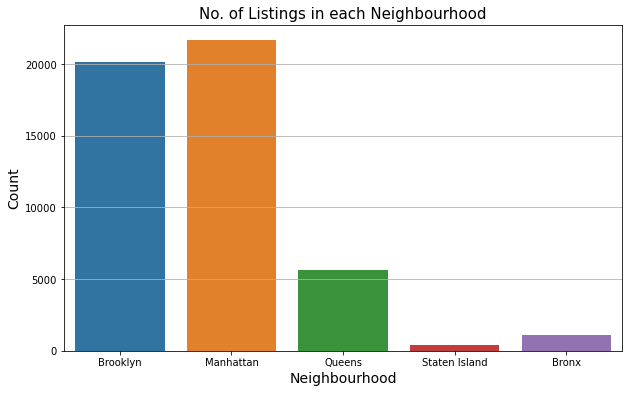

In [227]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="neighbourhood_group")
plt.grid(axis='y')
plt.title('No. of Listings in each Neighbourhood', fontsize=15)
plt.xlabel('Neighbourhood', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

#### Most of the listings in the dataset are for Brooklyn and Manhattan.

---

In [228]:
df.groupby(["neighbourhood_group"])["room_type"].value_counts()

neighbourhood_group  room_type      
Bronx                Private room         652
                     Entire home/apt      379
                     Shared room           60
Brooklyn             Private room       10132
                     Entire home/apt     9559
                     Shared room          413
Manhattan            Entire home/apt    13199
                     Private room        7982
                     Shared room          480
Queens               Private room        3372
                     Entire home/apt     2096
                     Shared room          198
Staten Island        Private room         188
                     Entire home/apt      176
                     Shared room            9
Name: room_type, dtype: int64

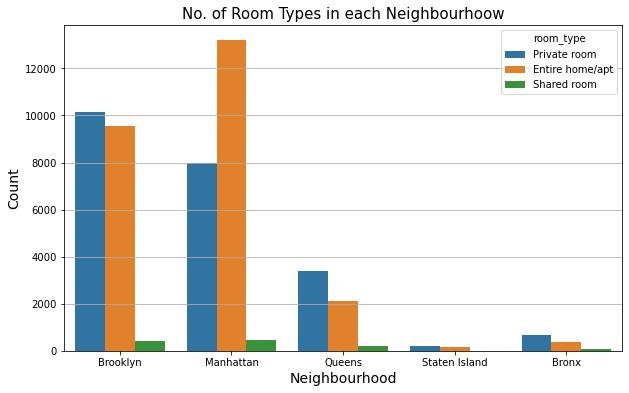

In [229]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="neighbourhood_group", hue="room_type")
plt.grid(axis='y')
plt.title('No. of Room Types in each Neighbourhoow', fontsize=15)
plt.xlabel('Neighbourhood', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

#### Most of the rooms are available in Brooklyn and Manhattan. And they are mainly 'Private Rooms' and 'Entire home/apt'. Not many for rent are shared, and very few are available in 'Staten Island' and the 'Bronx'.

---

In [230]:
df.groupby(["neighbourhood_group"])["price"].mean()

neighbourhood_group
Bronx             87.496792
Brooklyn         124.383207
Manhattan        196.875814
Queens            99.517649
Staten Island    114.812332
Name: price, dtype: float64

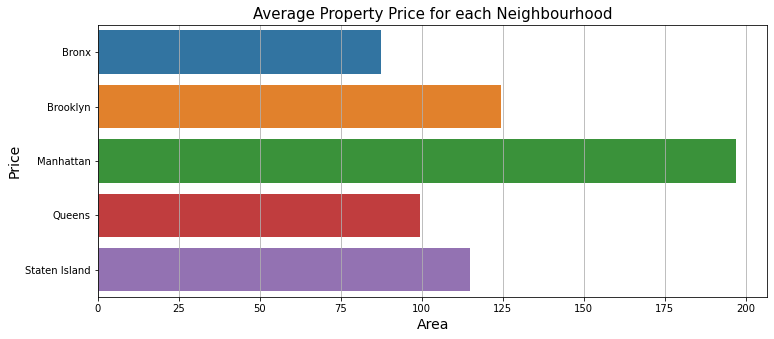

In [231]:
plt.figure(figsize=(12,5))
sns.barplot(y=df.groupby(["neighbourhood_group"])["price"].mean().index, x=df.groupby(["neighbourhood_group"])["price"].mean())
plt.grid(axis='x')
plt.title('Average Property Price for each Neighbourhood', fontsize=15)
plt.xlabel('Area', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.show()

#### Manhattan is the most expensive area to rent as compared to the other 4 areas.

---

In [232]:
df.groupby("room_type")["price"].mean()

room_type
Entire home/apt    211.794246
Private room        89.780973
Shared room         70.127586
Name: price, dtype: float64

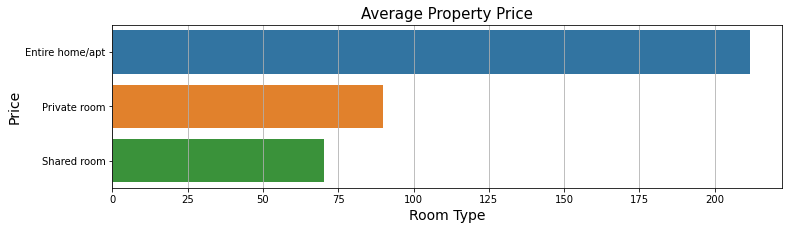

In [233]:
plt.figure(figsize=(12,3))
sns.barplot(y=df.groupby(["room_type"])["price"].mean().index, x=df.groupby(["room_type"])["price"].mean())
plt.grid(axis='x')
plt.title('Average Property Price', fontsize=15)
plt.xlabel("Room Type", fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.show()

#### Taking the average room price, renting an Entire Home/Apt would be most expensive.

---

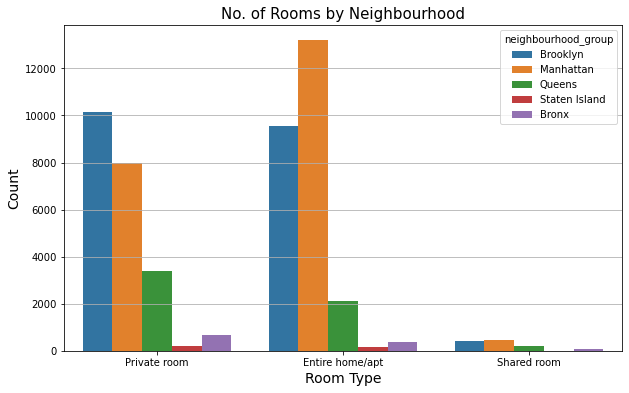

In [234]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="room_type", hue="neighbourhood_group")
plt.grid(axis='y')
plt.title('No. of Rooms by Neighbourhood', fontsize=15)
plt.xlabel("Room Type", fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

#### Not many hosts offer the option to share an apartment. Most of the available property on rent are either 'Private Rooms' or an 'Entire Home/Apt'

---

---

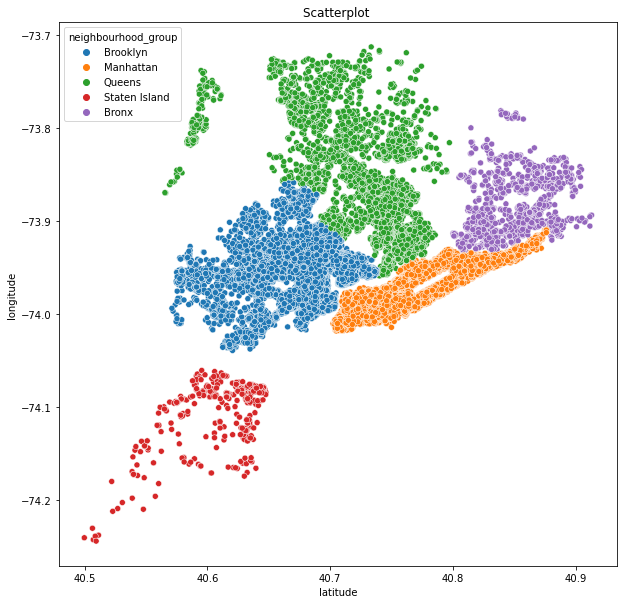

In [235]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=df['latitude'], y=df['longitude'], hue=df['neighbourhood_group'])
plt.title('Scatterplot ')
plt.show()

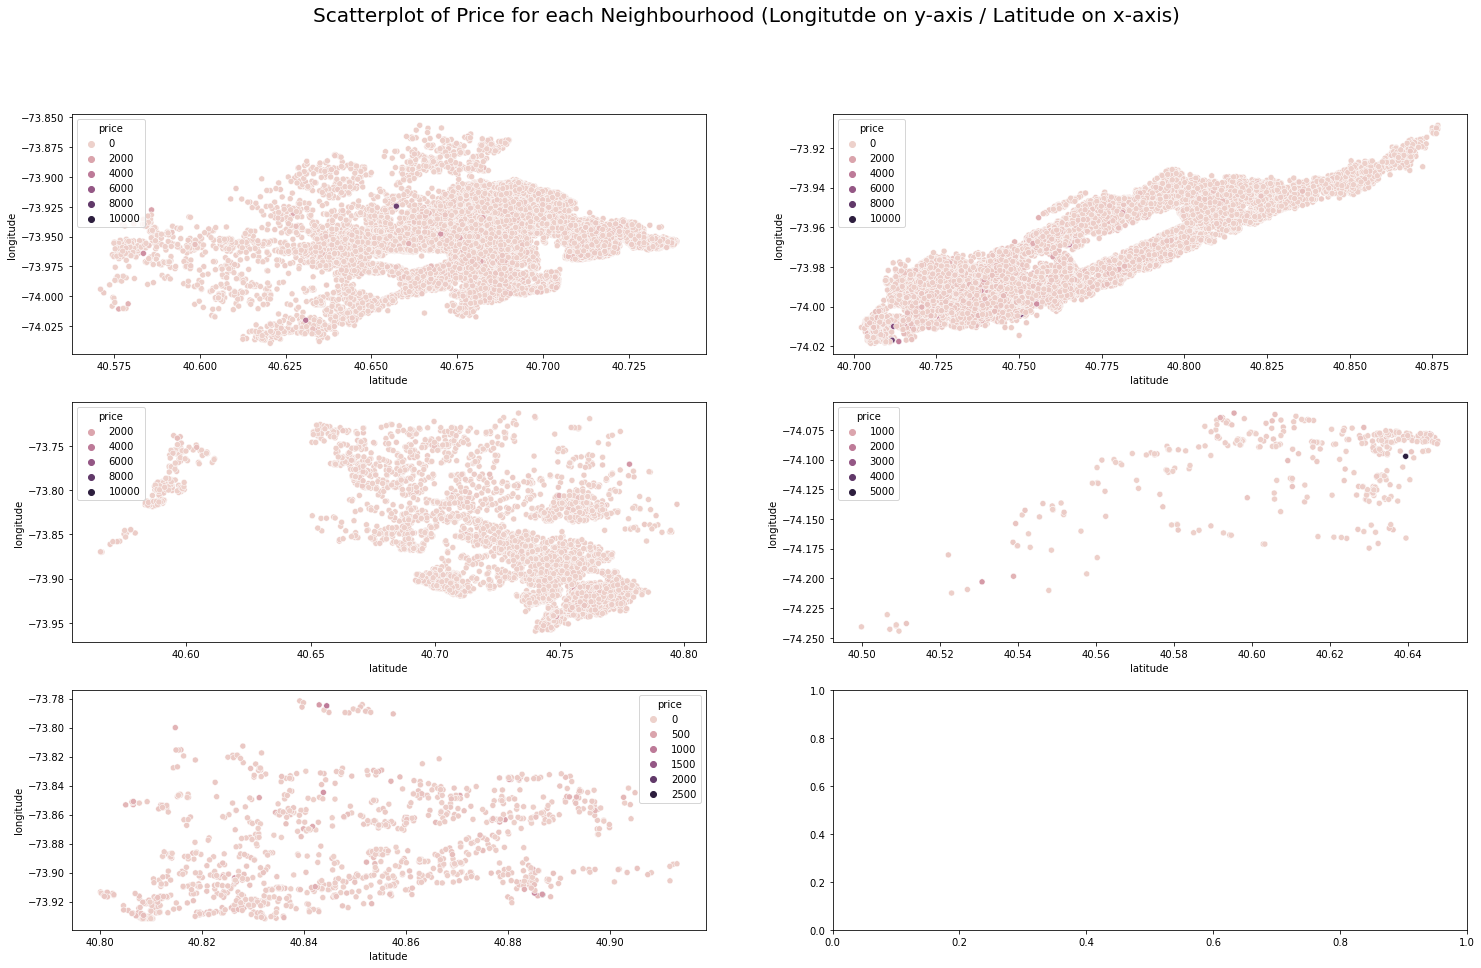

In [236]:
fig, axes = plt.subplots(3, 2, figsize=(25,15))

fig.suptitle("Scatterplot of Price for each Neighbourhood (Longitutde on y-axis / Latitude on x-axis)", fontsize=20)
sns.scatterplot(x=df['latitude'], y=df['longitude'], hue=df[df['neighbourhood_group'] == 'Brooklyn']['price'], ax=axes[0][0])
sns.scatterplot(x=df['latitude'], y=df['longitude'], hue=df[df['neighbourhood_group'] == 'Manhattan']['price'], ax=axes[0][1])
sns.scatterplot(x=df['latitude'], y=df['longitude'], hue=df[df['neighbourhood_group'] == 'Queens']['price'], ax=axes[1][0])
sns.scatterplot(x=df['latitude'], y=df['longitude'], hue=df[df['neighbourhood_group'] == 'Staten Island']['price'], ax=axes[1][1])
sns.scatterplot(x=df['latitude'], y=df['longitude'], hue=df[df['neighbourhood_group'] == 'Bronx']['price'], ax=axes[2][0])
plt.show()

---

In [237]:
df_cat = df[['neighbourhood_group', 'neighbourhood', 'room_type']]
df_cat.head()

,neighbourhood_group,neighbourhood,room_type
0,Brooklyn,Kensington,Private room
1,Manhattan,Midtown,Entire home/apt
2,Manhattan,Harlem,Private room
3,Brooklyn,Clinton Hill,Entire home/apt
4,Manhattan,East Harlem,Entire home/apt


In [238]:
df_num = df.drop(df_cat.columns.tolist() + ['price'], axis=1)
df_num.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,availability_365
0,40.64749,-73.97237,1,9,0.21,365
1,40.75362,-73.98377,1,45,0.38,355
2,40.80902,-73.94190,3,0,0.00,365
3,40.68514,-73.95976,1,270,4.64,194
4,40.79851,-73.94399,10,9,0.10,0


In [239]:
df.corr()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
latitude,1.000000,0.084788,0.033939,0.024869,-0.015389,-0.018758,-0.010983
longitude,0.084788,1.000000,-0.150019,-0.062747,0.059094,0.138516,0.082731
price,0.033939,-0.150019,1.000000,0.042799,-0.047954,-0.050564,0.081829
minimum_nights,0.024869,-0.062747,0.042799,1.000000,-0.080116,-0.124905,0.144303
number_of_reviews,-0.015389,0.059094,-0.047954,-0.080116,1.000000,0.589407,0.172028
reviews_per_month,-0.018758,0.138516,-0.050564,-0.124905,0.589407,1.000000,0.163732
availability_365,-0.010983,0.082731,0.081829,0.144303,0.172028,0.163732,1.000000


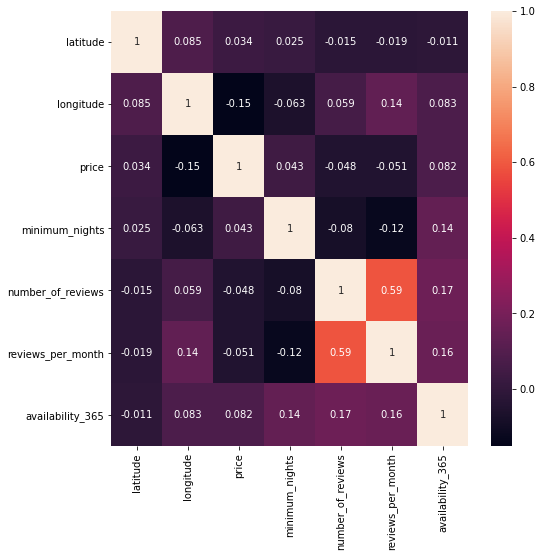

In [240]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

---

## Creating Models

#### All the models will be based on Regression Algorithms as price is Continuous.

## First Models

In [241]:
for cols in df_cat:
    le = LabelEncoder()
    df[cols] = le.fit_transform(df[cols])

In [242]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
0,1,108,40.64749,-73.97237,1,149,1,9,0.21,365
1,2,127,40.75362,-73.98377,0,225,1,45,0.38,355
2,2,94,40.80902,-73.94190,1,150,3,0,0.00,365
3,1,41,40.68514,-73.95976,0,89,1,270,4.64,194
4,2,61,40.79851,-73.94399,0,80,10,9,0.10,0


In [243]:
x = df.drop('price', axis=1)
y = df["price"]

In [244]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [245]:
def ml_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("MSE :", mean_squared_error(y_test, y_pred))
    print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2 Score ;", r2_score(y_test, y_pred))

In [246]:
ml_model(RandomForestRegressor())

MSE : 59121.28162384134
RMSE : 243.14868213469992
R2 Score ; 0.07830128357551436


In [247]:
ml_model(LinearRegression())

MSE : 59373.83791464113
RMSE : 243.66747405971347
R2 Score ; 0.07436393981940026


In [248]:
ml_model(AdaBoostRegressor())

MSE : 273130.9148316313
RMSE : 522.6192828739017
R2 Score ; -3.2581014264521837


In [249]:
ml_model(GradientBoostingRegressor())

MSE : 56111.66594842787
RMSE : 236.87901120282453
R2 Score ; 0.12522108688101263


In [250]:
ml_model(DecisionTreeRegressor())

MSE : 124694.14643624093
RMSE : 353.12058342192535
R2 Score ; -0.943977389515573


In [251]:
ml_model(XGBRegressor())

MSE : 57479.32319499006
RMSE : 239.748458170204
R2 Score ; 0.10389935815589191


In [252]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [253]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation='relu', input_shape=(X_train_ss.shape[1],)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [254]:
nn_model.compile(optimizer='adam', loss='mse')

In [255]:
nn_model.fit(X_train_ss, y_train, epochs=50, batch_size=10)

Epoch 1/50
3912/3912 [==============================] - 5s 1ms/step - loss: 78900.9297
Epoch 2/50
3912/3912 [==============================] - 4s 1ms/step - loss: 77854.3984
Epoch 3/50
3912/3912 [==============================] - 4s 1ms/step - loss: 76843.1328
Epoch 4/50
3912/3912 [==============================] - 4s 1ms/step - loss: 75864.7891
Epoch 5/50
3912/3912 [==============================] - 5s 1ms/step - loss: 74916.3516
Epoch 6/50
3912/3912 [==============================] - 5s 1ms/step - loss: 73988.7812
Epoch 7/50
3912/3912 [==============================] - 4s 1ms/step - loss: 73101.4297
Epoch 8/50
3912/3912 [==============================] - 4s 979us/step - loss: 72224.4531
Epoch 9/50
3912/3912 [==============================] - 4s 1ms/step - loss: 71395.1172
Epoch 10/50
3912/3912 [==============================] - 4s 1ms/step - loss: 70572.7109
Epoch 11/50
3912/3912 [==============================] - 4s 949us/step - loss: 69786.3594
Epoch 12/50
3912/3912 [==============

In [256]:
y_pred = nn_model.predict(X_test_ss)
mean_squared_error(y_test, y_pred)

64681.986188186325

In [257]:
np.sqrt(mean_squared_error(y_test, y_pred))

254.32653457354056

In [258]:
r2_score(y_test, y_pred)

-0.008389906442695771

#### Scores are very high. Let us perform One-Hot-Encoding on the data.

---

## Second Models

In [259]:
df = cleaning_data()

In [260]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,0


In [261]:
neighbourhood_group = pd.get_dummies(df['neighbourhood_group'])
room_type = pd.get_dummies(df['room_type'])

In [262]:
neighbourhood_group.head()

,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,0,1,0,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,0,1,0,0


In [263]:
room_type.head()

,Entire home/apt,Private room,Shared room
0,0,1,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


In [264]:
df = pd.concat([df, neighbourhood_group, room_type], axis=1)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,365,0,1,0,0,0,0,1,0
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,355,0,0,1,0,0,1,0,0
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,365,0,0,1,0,0,0,1,0
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,194,0,1,0,0,0,1,0,0
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,0,0,0,1,0,0,1,0,0


In [265]:
df_cat.head()

,neighbourhood_group,neighbourhood,room_type
0,Brooklyn,Kensington,Private room
1,Manhattan,Midtown,Entire home/apt
2,Manhattan,Harlem,Private room
3,Brooklyn,Clinton Hill,Entire home/apt
4,Manhattan,East Harlem,Entire home/apt


In [266]:
for cols in df_cat:
    le = LabelEncoder()
    df[cols] = le.fit_transform(df[cols])

In [267]:
df.drop(['neighbourhood_group', 'room_type'], axis=1, inplace=True)

In [268]:
x = df.drop('price', axis=1)
y = df["price"]

In [269]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [270]:
ml_model(RandomForestRegressor(n_estimators=200))

MSE : 57757.89047693442
RMSE : 240.3287133842613
R2 Score ; 0.09955650395595117


In [271]:
ml_model(LinearRegression())

MSE : 58850.47607474975
RMSE : 242.5911706446666
R2 Score ; 0.08252313263126443


In [272]:
ml_model(AdaBoostRegressor())

MSE : 104219.00016951977
RMSE : 322.82967671749105
R2 Score ; -0.6247705740626726


In [273]:
ml_model(GradientBoostingRegressor())

MSE : 56268.06976480065
RMSE : 237.20891586279097
R2 Score ; 0.12278275684426065


In [274]:
ml_model(DecisionTreeRegressor())

MSE : 123745.18969219757
RMSE : 351.7743448465189
R2 Score ; -0.9291831870067018


In [275]:
ml_model(XGBRegressor())

MSE : 57485.17655094336
RMSE : 239.76066514535566
R2 Score ; 0.10380810454093703


In [276]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [277]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation='relu', input_shape=(X_train_ss.shape[1],)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [278]:
nn_model.compile(optimizer='adam', loss='mse')

In [279]:
nn_model.fit(X_train_ss, y_train, epochs=50, batch_size=10)

Epoch 1/50
3912/3912 [==============================] - 4s 999us/step - loss: 54816.9453
Epoch 2/50
3912/3912 [==============================] - 4s 1ms/step - loss: 49970.9023
Epoch 3/50
3912/3912 [==============================] - 4s 1ms/step - loss: 49785.3125
Epoch 4/50
3912/3912 [==============================] - 4s 1ms/step - loss: 49708.4805
Epoch 5/50
3912/3912 [==============================] - 4s 1ms/step - loss: 49646.0508
Epoch 6/50
3912/3912 [==============================] - 4s 1ms/step - loss: 49603.8281
Epoch 7/50
3912/3912 [==============================] - 4s 1ms/step - loss: 49566.5156
Epoch 8/50
3912/3912 [==============================] - 4s 1ms/step - loss: 49547.4766
Epoch 9/50
3912/3912 [==============================] - 4s 1ms/step - loss: 49505.4688
Epoch 10/50
3912/3912 [==============================] - 4s 1ms/step - loss: 49488.5781
Epoch 11/50
3912/3912 [==============================] - 4s 1ms/step - loss: 49463.7031
Epoch 12/50
3912/3912 [================

In [280]:
y_pred = nn_model.predict(X_test_ss)
mean_squared_error(y_test, y_pred)

57552.796025528

In [281]:
np.sqrt(mean_squared_error(y_test, y_pred))

239.90163823018798

In [282]:
r2_score(y_test, y_pred)

0.10275391929294975

#### Even with one-hot enoding, our scores are not good. Let us look at the data once more.

---

## Third Models

In [283]:
df = cleaning_data()
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,0


In [284]:
df_num

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,availability_365
0,40.64749,-73.97237,1,9,0.21,365
1,40.75362,-73.98377,1,45,0.38,355
2,40.80902,-73.94190,3,0,0.00,365
3,40.68514,-73.95976,1,270,4.64,194
4,40.79851,-73.94399,10,9,0.10,0
...,...,...,...,...,...,...
48890,40.67853,-73.94995,2,0,0.00,9
48891,40.70184,-73.93317,4,0,0.00,36
48892,40.81475,-73.94867,10,0,0.00,27
48893,40.75751,-73.99112,1,0,0.00,2


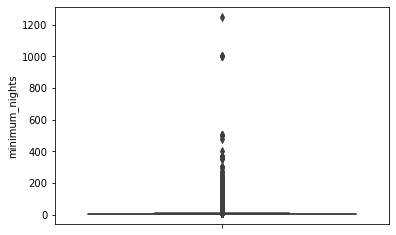

In [285]:
plt.figure()
sns.boxplot(y=df['minimum_nights'])
plt.show()

In [286]:
min(df['minimum_nights'])

1

In [287]:
max(df['minimum_nights'])

1250

#### The below link is to an article stating short-term AirBnb stays in New York

https://sharedeconomycpa.com/blog/nyc-airbnb-law/#:~:text=Airbnb%20NYC%20Law%3A%20How%20It%20Works&text=Rentals%20can%20exceed%2030%20days,the%20world's%20largest%20tourism%20destinations.

The article states that - 
- You can’t rent out an entire apartment for fewer than 30 days, even if you own or live in the building.
- If you are renting out a portion of your home for less than 30 days, you must be present during your guests’ stay.

Let us take a look at 'minimum_nights' for rows with values greater than 30 and less than 31.

In [288]:
len(df[df['minimum_nights']>30][df['room_type'] == 'Private room'])

226

In [289]:
len(df[df['minimum_nights']>30][df['room_type'] == 'Shared room'])

17

In [290]:
len(df[df['minimum_nights']>30][df['room_type'] == 'Entire home/apt'])

504

In [291]:
len(df[df['minimum_nights']<31][df['room_type'] == 'Private room'])

22100

In [292]:
len(df[df['minimum_nights']<31][df['room_type'] == 'Shared room'])

1143

In [293]:
len(df[df['minimum_nights']<31][df['room_type'] == 'Entire home/apt'])

24905

#### - From the above, we can see that most of the property given on rent have a minimum stay of 30 days or less. We can assume that the owner would be present when leasing out property for less than 30 days.
#### - Earlier, we saw that some owners had more than one listing. We can assume that they might only rent out one at a time, or that the property might actually be under a company. If under a company, the rules might be different. Meaning that the home owner would not need to be present when leasing out the property.
#### For the above two reasons, we will exclude all rows where the minimum stay is more than 30.

In [294]:
to_remove = df[df['minimum_nights']>30].index.tolist()
len(to_remove)

747

In [295]:
df.drop(to_remove, inplace=True)

In [296]:
for cols in df_cat:
    le = LabelEncoder()
    df[cols] = le.fit_transform(df[cols])

In [297]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
0,1,108,40.64749,-73.97237,1,149,1,9,0.21,365
1,2,127,40.75362,-73.98377,0,225,1,45,0.38,355
2,2,94,40.80902,-73.94190,1,150,3,0,0.00,365
3,1,41,40.68514,-73.95976,0,89,1,270,4.64,194
4,2,61,40.79851,-73.94399,0,80,10,9,0.10,0


In [298]:
x = df.drop('price', axis=1)
y = df["price"]

In [299]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [300]:
def ml_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("MSE :", mean_squared_error(y_test, y_pred))
    print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2 Score ;", r2_score(y_test, y_pred))

In [301]:
ml_model(RandomForestRegressor())

MSE : 46404.175541754936
RMSE : 215.41628430031685
R2 Score ; 0.011742957106600449


In [302]:
ml_model(LinearRegression())

MSE : 41660.21414696948
RMSE : 204.10833923916357
R2 Score ; 0.1127738062678485


In [303]:
ml_model(AdaBoostRegressor())

MSE : 89738.13011626135
RMSE : 299.56323225032367
R2 Score ; -0.9111284290285584


In [304]:
ml_model(GradientBoostingRegressor())

MSE : 39686.78794883877
RMSE : 199.2154310008107
R2 Score ; 0.15480132461429919


In [305]:
ml_model(DecisionTreeRegressor())

MSE : 116629.13842159917
RMSE : 341.51008538782446
R2 Score ; -1.483818882807709


In [306]:
ml_model(XGBRegressor())

MSE : 44983.0180243639
RMSE : 212.09200367850715
R2 Score ; 0.04200896031053292


In [307]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [308]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation='relu', input_shape=(X_train_ss.shape[1],)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [309]:
nn_model.compile(optimizer='adam', loss='mse')

In [310]:
nn_model.fit(X_train_ss, y_train, epochs=50, batch_size=10)

Epoch 1/50
3852/3852 [==============================] - 3s 834us/step - loss: 52175.8828
Epoch 2/50
3852/3852 [==============================] - 3s 872us/step - loss: 46477.7891
Epoch 3/50
3852/3852 [==============================] - 3s 904us/step - loss: 46299.1719
Epoch 4/50
3852/3852 [==============================] - 4s 934us/step - loss: 46195.6875
Epoch 5/50
3852/3852 [==============================] - 4s 918us/step - loss: 46112.7734
Epoch 6/50
3852/3852 [==============================] - 4s 922us/step - loss: 46092.8555
Epoch 7/50
3852/3852 [==============================] - 4s 910us/step - loss: 46065.1406
Epoch 8/50
3852/3852 [==============================] - 3s 908us/step - loss: 46008.9648
Epoch 9/50
3852/3852 [==============================] - 3s 899us/step - loss: 45974.2500
Epoch 10/50
3852/3852 [==============================] - 4s 914us/step - loss: 45962.7656
Epoch 11/50
3852/3852 [==============================] - 3s 904us/step - loss: 45903.1484
Epoch 12/50
3852/38

In [311]:
y_pred = nn_model.predict(X_test_ss)
mean_squared_error(y_test, y_pred)

39913.05137583964

In [312]:
np.sqrt(mean_squared_error(y_test, y_pred))

199.78251018505009

In [313]:
r2_score(y_test, y_pred)

0.14998265425387858

#### There does seem to be a slight improvement with the scores. We will try to improve them further.

---

## Forth Models

latitude - 0.23885551401666058


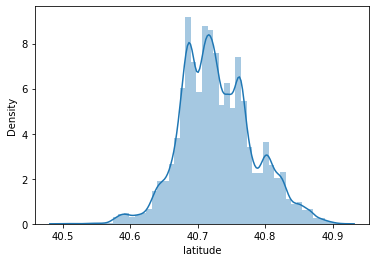


longitude - 1.2821791065131867


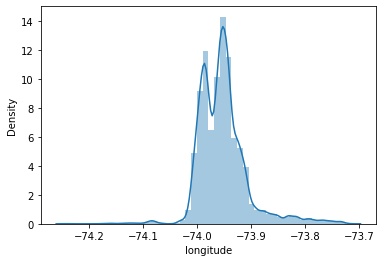


minimum_nights - 2.3519440868448553


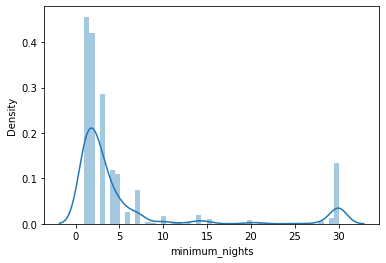


number_of_reviews - 3.674934014833137


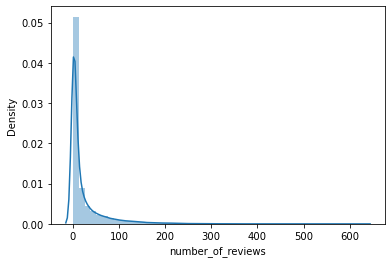


reviews_per_month - 3.2850380814956788


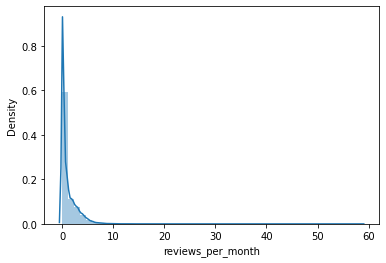


availability_365 - 0.7770339306085128


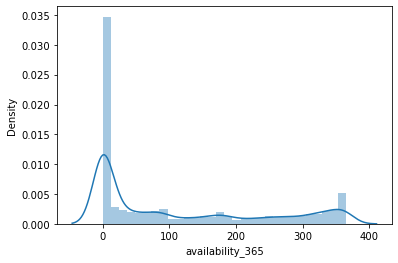

In [314]:
for cols in df_num:
    plt.figure()
    print(cols, "-", skew(df[cols]))
    sns.distplot(df[cols])
    plt.show()
    print()

#### The above block of code change some of the values to '-inf'. This is because the log of 0 is -infinity.
#### Adding a small value, 0.1, would give us a negative value. Our data cannot have any negative value. 
#### For this, we will add 1 to each value, so that the log of 1 will give us a 0 value.

In [315]:
df['minimum_nights'] = np.log(df['minimum_nights']+1)
df['number_of_reviews'] = np.log(df['number_of_reviews']+1)
df['reviews_per_month'] = np.log(df['reviews_per_month']+1)

In [316]:
x = df.drop('price', axis=1)
y = df["price"]

In [317]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [318]:
def ml_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("MSE :", mean_squared_error(y_test, y_pred))
    print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2 Score ;", r2_score(y_test, y_pred))

In [319]:
ml_model(RandomForestRegressor())

MSE : 48792.606826054005
RMSE : 220.8904860469414
R2 Score ; -0.03912281112694105


In [320]:
ml_model(LinearRegression())

MSE : 41336.30850373095
RMSE : 203.31332593740862
R2 Score ; 0.11967193621900707


In [321]:
ml_model(AdaBoostRegressor())

MSE : 398520.98232558486
RMSE : 631.285183039793
R2 Score ; -7.487192433139407


In [322]:
ml_model(GradientBoostingRegressor())

MSE : 39759.297445517026
RMSE : 199.3973356028536
R2 Score ; 0.15325710968250994


In [323]:
ml_model(DecisionTreeRegressor())

MSE : 113476.27840083074
RMSE : 336.86240277126615
R2 Score ; -1.4166732847143266


In [324]:
ml_model(XGBRegressor())

MSE : 44982.96553520027
RMSE : 212.09187993697512
R2 Score ; 0.04201007815790381


In [325]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [332]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation='relu', input_shape=(X_train_ss.shape[1],)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [333]:
nn_model.compile(optimizer='adam', loss='mse')

In [338]:
nn_model.fit(X_train_ss, y_train, epochs=50, batch_size=10)

Epoch 1/50
3852/3852 [==============================] - 4s 1ms/step - loss: 69242.5469
Epoch 2/50
3852/3852 [==============================] - 4s 1ms/step - loss: 68368.1484
Epoch 3/50
3852/3852 [==============================] - 4s 1ms/step - loss: 67537.6406
Epoch 4/50
3852/3852 [==============================] - 5s 1ms/step - loss: 66741.6641
Epoch 5/50
3852/3852 [==============================] - 5s 1ms/step - loss: 65955.0625
Epoch 6/50
3852/3852 [==============================] - 4s 992us/step - loss: 65200.1797
Epoch 7/50
3852/3852 [==============================] - 4s 946us/step - loss: 64474.9688
Epoch 8/50
3852/3852 [==============================] - 4s 923us/step - loss: 63776.6406
Epoch 9/50
3852/3852 [==============================] - 4s 926us/step - loss: 63104.3398
Epoch 10/50
3852/3852 [==============================] - 4s 921us/step - loss: 62454.9961
Epoch 11/50
3852/3852 [==============================] - 4s 929us/step - loss: 61838.5234
Epoch 12/50
3852/3852 [======

In [339]:
y_pred = nn_model.predict(X_test_ss)
mean_squared_error(y_test, y_pred)

47288.25422180912

In [340]:
np.sqrt(mean_squared_error(y_test, y_pred))

217.45862645986045

In [341]:
r2_score(y_test, y_pred)

-0.007085024897934611

# Conclusion

#### The models that produced the best scores were GradientBoosting and NeuralNetwork from the 3rd model set.